# Interactions between ProTα and Histone H1.0

In [1]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

## Strategy

Ionic strength range in Borgia et al. 2018
- *In vitro* FRET [mM]: 165, 180, 205, 240, 290, 330, 340
- *In silico* coarse grain [mM]: 165

They do not report a box size, but report interactions starting from 22 nm COM distance as well as 7 fM KD from CG MD.

$K_{D} = $

## Data preparation

### Templates

In [7]:
# Defining UniProt IDs / Trivial IDs
entries = {
    'H1-0': 'P07305',
    'ProTa': 'P06454',
}
templates = pd.DataFrame({'uniprot_id': entries.values(),
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None},
                          index=entries.keys())

In [8]:
# Collecting metadata
for id, row in templates.iterrows():
    name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    templates.loc[id] = {
        'uniprot_id': row.uniprot_id,
        'name': name,
        'description': desc,
        'species': spec,
        'sequence': seq}

In [9]:
# Viewing final templates
templates

,uniprot_id,name,description,species,sequence
H1-0,P07305,H10_HUMAN,Histone H1.0,Homo sapiens (Human),MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...
ProTa,P06454,PTMA_HUMAN,Prothymosin alpha,Homo sapiens (Human),MSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNAENEENGE...


In [10]:
# Saving metadata
metadata = {'templates': templates.to_dict(orient='index')}
with open('prota_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Data

In [9]:
# Getting template metadata
with open('prota_h1-0.json', 'r') as file:
    metadata = json.load(file)

In [12]:
# Getting IDR of H1.0 (C-terminal IDR)
seq, loc, reg = data_utils.get_protein_idr(uniprot_id=metadata['templates']['H1-0']['uniprot_id'], i_idr=-1, length_order=False)
H10 = {'template': 'H1-0', 'sequence': seq, 'location': loc, 'region': 'CTD', 'variant': 'Wild type'}

# Getting IDR of ProTa (Full-length IDP)
seq, loc, reg = data_utils.get_protein_idr(uniprot_id=metadata['templates']['ProTa']['uniprot_id'], i_idr=-1, length_order=True)
ProTa = {'template': 'ProTa', 'sequence': seq, 'location': loc, 'region': 'FL', 'variant': 'Wild type'}

In [13]:
# Assembling all data entries for simulation
data = pd.DataFrame([H10, ProTa], index = ['H1-0_WT', 'ProTa_WT'])
data

,template,sequence,location,region,variant
H1-0_WT,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type
ProTa_WT,ProTa,MSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNAENEENGE...,0:111,FL,Wild type


In [14]:
# Saving sequences
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Iterating over rows
for index, cols in data.iterrows():
    id = index.upper()
    desc = cols['variant']
    seq = cols['sequence']

    # Saving as FASTA format (Though one-line sequence)
    filepath = 'data/' + id + '.fasta'
    with open(filepath, 'w') as file:
        file.write('>' + id + ' ' + desc + '\n')
        file.write(seq + '\n')

In [16]:
# Saving metadata
metadata['data'] = data.to_dict(orient='index')
with open('prota_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Topologies

#### Compact frames

In [ ]:
# Getting compact frame topologies
cond = 'default'
trajs = {}

# Looping over proteins
for prot in ['PROTA_WT', 'H1-0_WT']:

    # Loading trajectory
    traj_path = f'results/single_chain/{cond}/{prot}/traj.dcd'
    top_path  = f'results/single_chain/{cond}/{prot}/top.pdb'

    # Selecting most compact frame
    compact_frame = analyse_utils.compact_frame(traj_path, top_path)
    trajs[prot] = compact_frame
trajs

In [ ]:
# Saving single topologies
for prot, traj in trajs.items():
    traj.save_pdb(f'data/{prot}.pdb')

#### Merging

In [39]:
# Loading trajectory
trajs = []
for prot in ['PROTA_WT', 'H1-0_WT', 'PROTA_WT']:
    top_path  = f'data/{prot}.pdb'
    trajs.append(md.load(top_path))
trajs

[<mdtraj.Trajectory with 1 frames, 111 atoms, 111 residues, and unitcells at 0x7efe254ec250>,
 <mdtraj.Trajectory with 1 frames, 111 atoms, 111 residues, and unitcells at 0x7efe25323c10>,
 <mdtraj.Trajectory with 1 frames, 111 atoms, 111 residues, and unitcells at 0x7efe25404610>]

In [40]:
# Translating topologies
translate_x = 10 # nm
translate_y = 0 # nm
translate_z = 0 # nm
for i, traj in enumerate(trajs):
    traj.xyz += [translate_x*i, translate_y*i, translate_z*i]

In [41]:
# Merging topologies
merged_traj = simulate_utils.merge_topologies(trajs, boxlength=100)

In [42]:
# Saving merged topologies
filename = 'data/H1-0_2xPROTA_WT.pdb'
merged_traj.save(filename)

# Identifying chains
simulate_utils.extract_sequences(filename).groupby('chain').q.sum(numeric_only=True)

chain
0   -44
1    42
2   -44
Name: q, dtype: int64

## Analysis

### Wild type ProTa - H1.0[CTD]

In [2]:
# Loading trajectory
traj = md.load_dcd("results/two_chain/traj.dcd", "results/two_chain/top.pdb")
residues = simulate_utils.extract_sequences("results/two_chain/top.pdb")

In [3]:
# Mapping chains to proteins
chain_map = {
    0: 'ProTa',
    1: 'H1-0 CTD'
}
residues['chain_id'] = residues['chain'].map(chain_map)
residues.groupby('chain_id').q.sum()

chain_id
H1-0 CTD    42
ProTa      -44
Name: q, dtype: int64

#### Contact maps

In [5]:
# Calculating distances
distances = analyse_utils.compute_distance_contact(traj)

In [6]:
# Defining distance masks
intra_mask = []
for i in residues.res:
    for j in residues.res:
        intra_mask.append(residues.chain[i] == residues.chain[j])
intra_mask = np.reshape(intra_mask, [len(residues)]*2)
inter_mask = ~intra_mask

/tmp/ipykernel_25265/3675497018.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(distances.mean(axis=0)[:prota_len,prota_len:], vmin=0, cmap=plt.cm.get_cmap('Blues_r'))


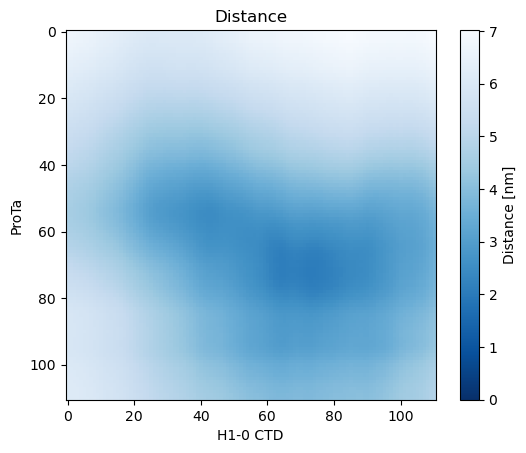

In [26]:
# Plotting distance contact map
prota_len = (residues['chain_id'] == 'ProTa').sum()
plt.imshow(distances.mean(axis=0)[:prota_len,prota_len:], vmin=0, cmap=plt.cm.get_cmap('Blues_r'))
plt.title("Distance")
plt.xlabel("H1-0 CTD")
plt.ylabel("ProTa")
plt.colorbar(label="Distance [nm]")

In [29]:
# Calculating interaction energies
energies = {
    'Ashbaugh-Hatch': 'AH',
    'Debye-Hückel': 'DH'#,
    #'Harmonic': 'HB'
}
for p, e in energies.items():
    energies[p] = analyse_utils.compute_energy(''.join(residues.aa), traj, potentials=[e])
    energies[p] = md.geometry.squareform(energies[p].T, traj.top.select_pairs('all','all'))

/tmp/ipykernel_25265/1601908699.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(e.mean(axis=0)[:prota_len,prota_len:]*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Blues_r'))


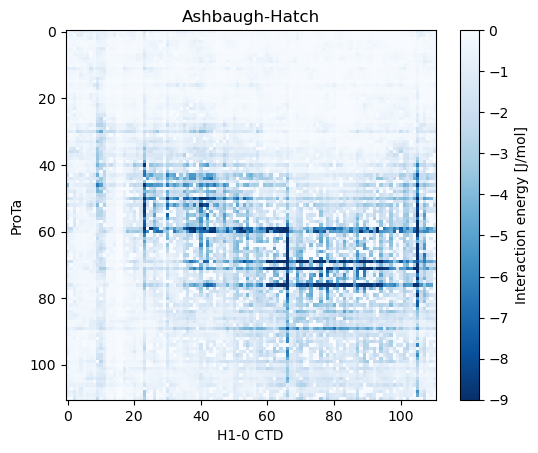

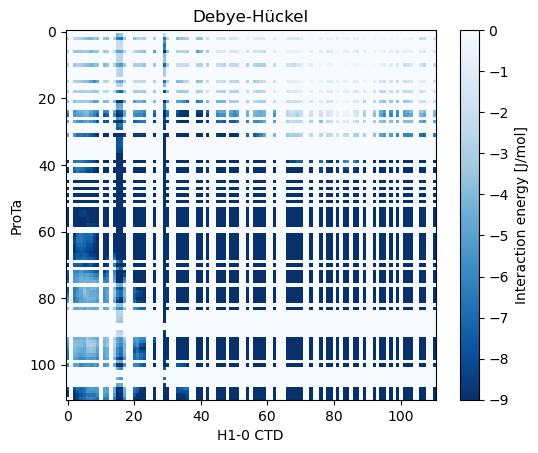

/tmp/ipykernel_25265/1601908699.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(sum(energies.values()).mean(axis=0)[:prota_len,prota_len:]*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Blues_r'))


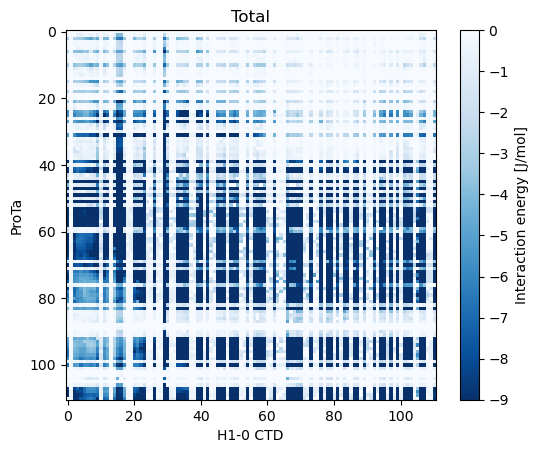

In [30]:
# Plotting energy contact maps
for p, e in energies.items():
    plt.imshow(e.mean(axis=0)[:prota_len,prota_len:]*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Blues_r'))
    plt.title(p)
    plt.xlabel("H1-0 CTD")
    plt.ylabel("ProTa")
    plt.colorbar(label="Interaction energy [J/mol]")
    plt.show()

plt.imshow(sum(energies.values()).mean(axis=0)[:prota_len,prota_len:]*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Blues_r'))
plt.title("Total")
plt.xlabel("H1-0 CTD")
plt.ylabel("ProTa")
plt.colorbar(label="Interaction energy [J/mol]")
plt.show()

#### Center of mass

In [10]:
# Computing center of mass for each protein
com_H10 = analyse_utils.compute_com(''.join(residues.aa[residues.chain_id == 'H1-0 CTD']), traj.atom_slice(residues.res[residues.chain_id == 'H1-0 CTD']))
com_ProTa = analyse_utils.compute_com(''.join(residues.aa[residues.chain_id == 'ProTa']), traj.atom_slice(residues.res[residues.chain_id == 'ProTa']))

In [18]:
# Compputing eucledian distance between COM
com_diff = (((com_H10-com_ProTa)**2).sum(axis=1))**0.5

Text(0, 0.5, 'Euclidean distance [nm]')

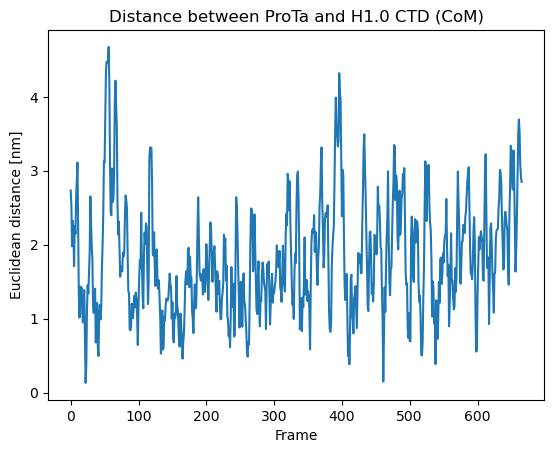

In [27]:
# Plotting COM difference over time
plt.plot(com_diff)
plt.title("Distance between ProTa and H1.0 CTD (CoM)")
plt.xlabel("Frame")
plt.ylabel("Euclidean distance [nm]")

Text(0, 0.5, 'Count')

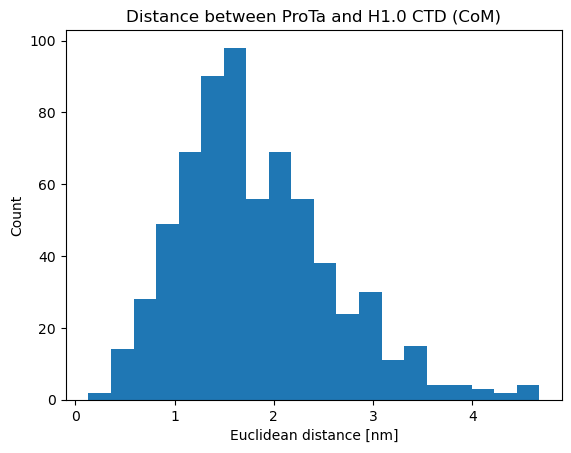

In [28]:
# Plotting COM difference over time
plt.hist(com_diff, bins=20)
plt.title("Distance between ProTa and H1.0 CTD (CoM)")
plt.xlabel("Euclidean distance [nm]")
plt.ylabel("Count")

In [29]:
# Saving topology of furthest-distance frame
traj[com_diff == com_diff.max()].save('distant.pdb')